In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import re

# Setting up visualization style
sns.set_theme(style="whitegrid")
%matplotlib inline

# Data Loading

In [19]:
# Loading the dataset directly from GitHub for reproducibility
# Tip: Upload the 'ai4i2020.csv' to your repo and use the 'Raw' link here
url = "https://raw.github.com/luisedugdasilva/Predictive-Maintenance/main/ai4i2020.csv"
df = pd.read_csv(url)

# Rename columns to remove special characters and make them easier to use
df.columns = [re.sub(r'\[.*?\]', '', col).strip().replace(' ', '_') for col in df.columns]

# Displaying the first few rows to verify the data
print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [20]:
# Remove the ‘UDI’ and ‘Product_ID’ columns, which are only identifiers.

df = df.drop(['UDI', 'Product_ID'], axis=1)

# Exploratory Data Analysis (EDA)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air_temperature      10000 non-null  float64
 2   Process_temperature  10000 non-null  float64
 3   Rotational_speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool_wear            10000 non-null  int64  
 6   Machine_failure      10000 non-null  int64  
 7   TWF                  10000 non-null  int64  
 8   HDF                  10000 non-null  int64  
 9   PWF                  10000 non-null  int64  
 10  OSF                  10000 non-null  int64  
 11  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [22]:
# Applies One-Hot Encoding to the ‘Type’ column, transforming each unique category into a new binary column (0 or 1).
# The ‘prefix='Type’' parameter adds the prefix “Type_” to the new columns for easy identification.
# ‘dtype=int’ ensures that the values are integers (0 and 1) rather than booleans.

df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type', dtype=int)

# Display the first few rows of the new DataFrame to see the transformation
print("DataFrame após o One-Hot Encoding:")
df_encoded.head()

DataFrame após o One-Hot Encoding:


,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0,1,0


Distribuição da variável 'Machine_failure':
Machine_failure
0    9661
1     339
Name: count, dtype: int64


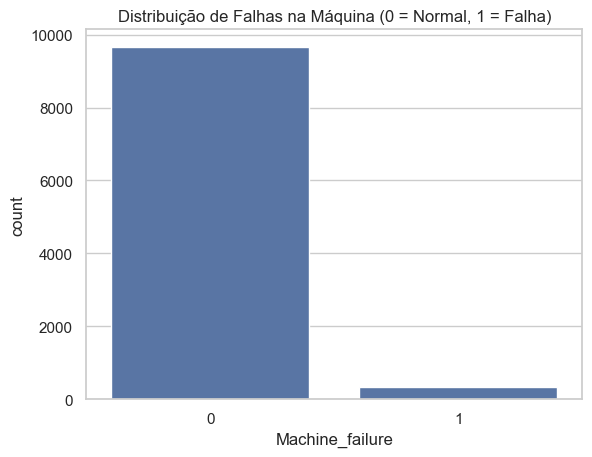

In [23]:
# Counting the number of failures vs. non-failures
print("Distribuição da variável 'Machine_failure':")
print(df_encoded['Machine_failure'].value_counts())

# Plot the distribution for visualization
sns.countplot(x='Machine_failure', data=df)
plt.title('Distribuição de Falhas na Máquina (0 = Normal, 1 = Falha)')
plt.show()

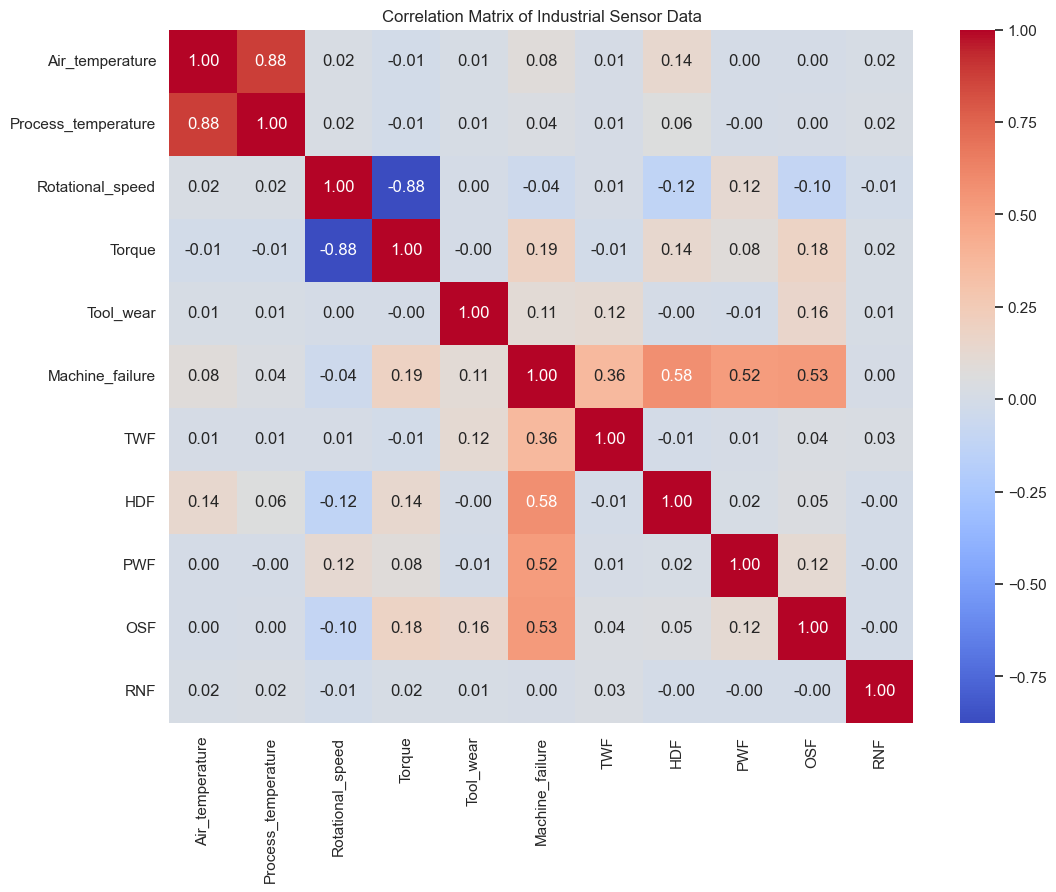

Class distribution before balancing:
Machine_failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [24]:
# Identifying correlations between numerical variables
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Industrial Sensor Data")
plt.show()

# Observing the target class distribution (Machine_failure)
print("Class distribution before balancing:")
print(df['Machine_failure'].value_counts(normalize=True))

# Feature Engineering

In [25]:
# Creating domain-specific features to enhance model performance
# Power = Torque * Rotational_speed (Physical relationship in tightening tools)
df['Power'] = df['Torque'] * df['Rotational_speed']

# Temp_Diff = Process temperature difference relative to air temperature
df['Temp_Diff'] = df['Process_temperature'] - df['Air_temperature']

# Encoding the 'Type' column (H/L/M) using One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Data Splitting & Balancing (SMOTE)

In [26]:
# Splitting the data into features (X) and target (y)
X = df_encoded.drop('Machine_failure', axis=1)
y = df_encoded['Machine_failure']

# Stratified split to maintain failure proportion in test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original training shape: {Counter(y_train)}")
print(f"Resampled training shape: {Counter(y_train_res)}")

Original training shape: Counter({0: 7729, 1: 271})
Resampled training shape: Counter({0: 7729, 1: 7729})


# Model Training & Evaluation

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define the model dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Create a list to store the results
results_list = []

print("Starting model benchmarking...")

# Training and evaluation loop
for name, model in models.items():
    # Train the model with balanced data (SMOTE)
    model.fit(X_train_res, y_train_res)
    
    # Making predictions on the original (unbalanced) test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics focused on Class 1 (Failure)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save to results dictionary
    results_list.append({
        "Model": name,
        "Precision (Fail)": round(precision, 3),
        "Recall (Fail)": round(recall, 3),
        "F1-Score (Fail)": round(f1, 3),
        "Accuracy": round(accuracy, 3)
    })

# Convert to DataFrame for easier visualization
df_results = pd.DataFrame(results_list).sort_values(by="F1-Score (Fail)", ascending=False)

print("\n--- Model Comparison Results ---")
print(df_results)

Starting model benchmarking...


C:\Users\Luis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Model Comparison Results ---
                 Model  Precision (Fail)  Recall (Fail)  F1-Score (Fail)  \
3              XGBoost             0.863          0.926            0.894   
1        Random Forest             0.717          0.971            0.825   
2    Gradient Boosting             0.541          0.971            0.695   
0  Logistic Regression             0.421          0.941            0.582   

   Accuracy  
3     0.993  
1     0.986  
2     0.971  
0     0.954  
